In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n = 10
y = np.arange(1, n+1) / n
y

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## Setup

In [3]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 100) 
        self.fc_apt_2 = nn.Linear(100, 50)
        self.fc_apt_3 = nn.Linear(50, 10)
        
        self.fc_pep_1 = nn.Linear(160, 50)
        self.fc_pep_2 = nn.Linear(50, 10)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 50, 3) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3) 
        self.cnn_apt_4 = nn.Conv1d(25, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(30, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 500, 3) 
        self.cnn_apt_2 = nn.Conv1d(500, 250, 3)
        self.cnn_apt_3 = nn.Conv1d(250, 125, 3)
        self.cnn_apt_4 = nn.Conv1d(125, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3)
        self.cnn_pep_3 = nn.Conv1d(250, 50, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(100, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        #print("apt1: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        #print("apt2: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        #print("apt3: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        #print("apt4: ", apt.size()) (1, 50, 1)
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        #print("pep1: ", pep.size())
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        #print("pep2: ", pep.size())
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        #print("pep3: ", pep.size()) (1, 50, 1)
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        print("cat: ", x.size())
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3) 
        self.cnn_apt_2 = nn.Conv1d(1000, 800, 3)
        self.cnn_apt_3 = nn.Conv1d(800, 600, 3)
        self.cnn_apt_4 = nn.Conv1d(600, 400, 3)
        self.cnn_apt_5 = nn.Conv1d(400, 200, 1)
        self.cnn_apt_6 = nn.Conv1d(200, 100, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 1000, 3)
        self.cnn_pep_2 = nn.Conv1d(1000, 800, 1)
        self.cnn_pep_3 = nn.Conv1d(800, 500, 1)
        self.cnn_pep_4 = nn.Conv1d(500, 250, 1)
        self.cnn_pep_5 = nn.Conv1d(250, 100, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(200, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))
        print(apt.size())
        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [10]:
class VariedChannelsNet(nn.Module):
    def __init__(self):
        super(VariedChannelsNet, self).__init__()
        self.name = "VariedChannelsNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(800, 600, 3, padding=2)
        self.cnn_apt_4 = nn.Conv1d(600, 400, 3, padding=2)
        self.cnn_apt_5 = nn.Conv1d(400, 200, 3, padding=2)
        self.cnn_apt_6 = nn.Conv1d(200, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 450, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(450, 400, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(400, 350, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(350, 250, 3, padding=2)
        self.cnn_pep_6 = nn.Conv1d(250, 200, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        # conv --> relu --> pool after every one
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_6(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class MinimizedVCNet(nn.Module):
    def __init__(self):
        super(MinimizedVCNet, self).__init__()
        self.name = "MinimizedVCNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 500, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(500, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(250, 100, 3, padding=2)

        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        # conv --> relu --> pool after every one
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

In [13]:
## Testing NN models
# model = ConvNetComplex()
# model.apply(weights_init)
# model.to(device)
# aptamer, peptide, (apt_prime, pep_prime), indicator = train_ds[0]
# a, p = convert(aptamer, peptide)
# output = model(a, p)
# print(output)

## Helper methods

In [14]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.to(device)
        y = pep.to(device)
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, m, lamb, gamma):
    n = i+j*m
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("%d number of samples" %n)
    plt.title("Loss at epoch %d," %j + " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/loss.png', bbox_inches='tight')
    plt.show()

def plot_recall(train_recall, test_recall, i, j, m, lamb, gamma):
    n = i+j*m
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("%d number of samples" %n)
    plt.title("Recall at epoch %d," %j + " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/recall.png', bbox_inches='tight')
    plt.show()
    

def plot_ecdf_test(test_score, i, j, m, lamb, gamma):
    n = i+j*m
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += 'y'
        else:
            test_c += 'g'
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.xlabel('CDF')
    plt.ylabel('Most recent 10,000 samples')
    plt.title('CDF after ' + str(i) + ' iterations, ' + str(j) + ' epochs, ' + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.savefig('plots/test_cdf.png', bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, i, j, m, lamb, gamma):
    #train_score consisits of [10000 scores generated] + [1000 scores from training set]
    n = i+j*m
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.xlabel("CDF")
    plt.ylabel("Most recent 10,000 samples after training %d samples" %n)
    plt.title('Train CDF')
    plt.legend()
    plt.savefig('plots/train_cdf.png', bbox_inches='tight')
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=ax)
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=ax)
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=ax)
    ax.set_title("Distribution of Scores")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/histogram.png', bbox_inches='tight')
    plt.show()

In [15]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [16]:
'''
lamb = hyperparameter
gamma = step size
run_from_checkpoint = path to a checkpointed model
save_checkpoings = file name
'''
def sgd(epochs=[5, 4, 3], 
        lambdas=[10, 9, 8], 
        gammas=[1e-3, 1e-4, 1e-5], 
        run_from_checkpoint=None, 
        save_checkpoints=None): 
    
    init_epoch = 0
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optim = SGD(model.parameters(), lr=gammas[0])
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
    
    model.to(device)
    total_epochs = init_epoch
    train_losses = []
    test_losses = []
    train_recalls = []
    test_recalls = []
    train_correct = 0
    test_correct = 0
    train_recall_outputs = [] 
    test_recall_outputs = []
    new_outputs = []
    
    for i in range(len(epochs)):
        g = gammas[i]
        l = lambdas[i]
        eps = epochs[i]
        epoch = 0
        optim = SGD(model.parameters(), lr=g)
        while epoch < eps:
            print("Training Epoch: ", total_epochs)
            
            for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
                if i == 0:
                    continue
                model.train()
                optim.zero_grad() 
                x, y = convert(aptamer, peptide) #sample x,y from S_train
                out = update(x, y) #get S_train output/score
                log_out = torch.log(out) 

                train_score = out.cpu().detach().numpy().flatten()[0] 
                if train_score > 0.6:
                    train_correct += 1 
                train_recall_outputs.append(train_score) 

                optim.zero_grad() 
                y_pmf = get_y_pmf(pep_prime)
                x_prime, y_prime = convert(apt_prime, pep_prime) #sample x', y' from S_prime_train
                out_prime = update(x_prime, y_prime) #get score from S_prime_train
                if indicator == 0:
                    factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
                else:
                    factor = 2
                out_prime = out_prime*factor #adjust for IS
                #print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*indicator)
                #print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
                # Retain graph retains the graph for further operations
                (l*indicator*out_prime - log_out).backward(retain_graph=True) 
                optim.step()

                with torch.no_grad():
                    model.eval()

                x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
                test_recall_outputs.append(test_score) 
                if test_score > 0.6:
                    test_correct += 1 

                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                    new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                    new_outputs.append(new_score)

                if i % 20000 == 0:
                    train_loss = l*get_out_prime("train") - get_log_out('train') #training loss
                    #print("Train loss first part: ", lamb*get_out_prime("train"))
                    #print("Train loss second part: ", get_log_out('train'))
                    test_loss = (m/(n-m))*l*get_out_prime("test") - get_log_out('test') #test loss
                    #print("Test loss first part: ", lamb*get_out_prime("test"))
                    #print("Test loss second part: ", get_log_out('test'))
                    train_losses.append(train_loss)
                    test_losses.append(test_loss)

                    train_recall = 100*train_correct/(total_epochs*m + i) #training recall
                    train_recalls.append(train_recall) 
                    test_recall = 100*test_correct/(total_epochs*m + i) #test recall
                    test_recalls.append(test_recall)
                    if i > 1000:
                        train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                        test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                    else:
                        train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                        test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores


                if i % 200000 == 0:
                    plot_recall(train_recalls, test_recalls, i, total_epochs, m, l, g)
                    plot_loss(train_losses, test_losses, i, total_epochs, m, l, g)
                    plot_ecdf_train(train_score, i, total_epochs, m, l, g)
                    plot_ecdf_test(test_score, i, total_epochs, m, l, g)
                    histogram(new_outputs[-1000:], train_recall_outputs[-1000:], test_recall_outputs[-1000:])
                    print("New score: ", np.average(new_outputs[-500:]))
                    print("Train score: ", np.average(train_score[-500:]))
                    print("Test score: ", np.average(test_score[-500:]))
        
            # Save after every epoch
            total_epochs += 1
            epoch += 1
            if save_checkpoints is not None:
                print("Saving to: ", save_checkpoints)
                checkpoint_name = save_checkpoints
                torch.save({'epoch': total_epochs,
                            'model_state_dict': model.state_dict(), 
                            'optimizer_state_dict': optim.state_dict()}, checkpoint_name)


## Hyperparameter tuning

In [17]:
# Hyperparameter search
GAMMAS = [1e-2, 5e-3, 1e-3, 5e-4]
LAMBDAS = [2, 2, 2, 2]
EPOCHS = [1, 1, 1, 2]

  0%|          | 0/473047 [00:00<?, ?it/s]

Training Epoch:  0


 42%|████▏     | 200000/473047 [2:19:20<3:08:42, 24.11it/s]   

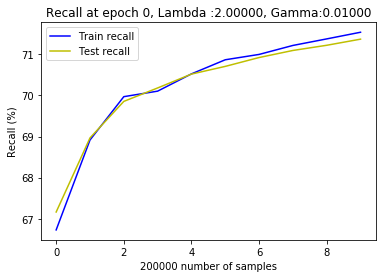

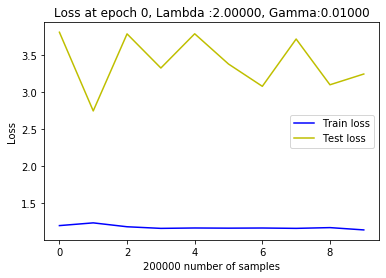

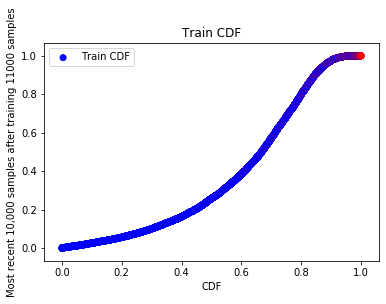

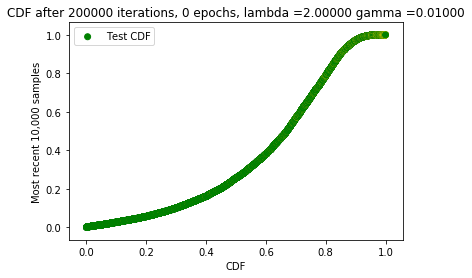

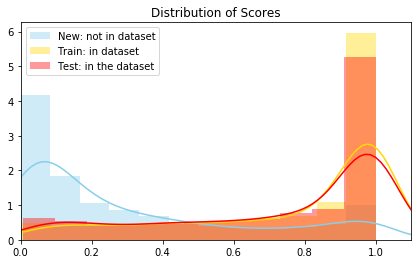

 42%|████▏     | 200004/473047 [2:20:12<1092:07:24, 14.40s/it]

New score:  0.30894145
Train score:  0.7524775
Test score:  0.7357625


 85%|████████▍ | 399998/473047 [4:40:50<48:55, 24.88it/s]     

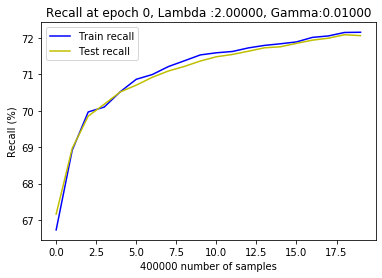

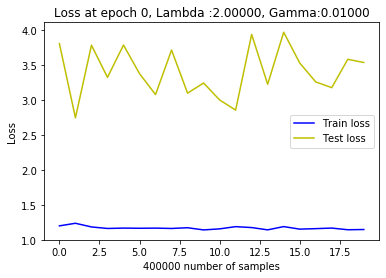

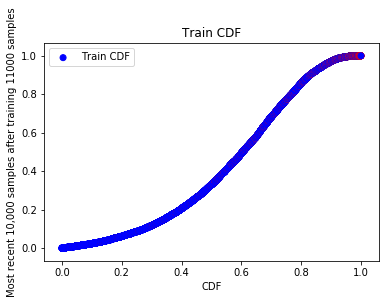

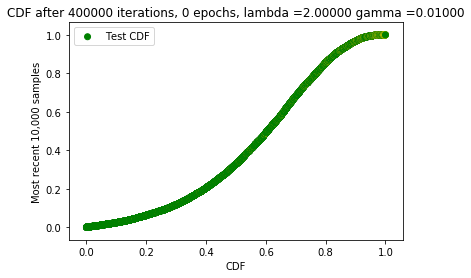

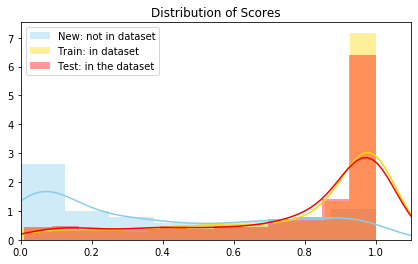

 85%|████████▍ | 400004/473047 [4:41:43<99:44:18,  4.92s/it] 

New score:  0.41468808
Train score:  0.7794975
Test score:  0.80089223


  0%|          | 4/473047 [00:00<4:01:20, 32.67it/s]

Saving to:  model_checkpoints/MinimizedVCNet/05072020.pth
Training Epoch:  1


 12%|█▏        | 56114/473047 [38:01<4:43:08, 24.54it/s]   

In [ ]:
model = MinimizedVCNet()
checkpoint = None
save_path = 'model_checkpoints/MinimizedVCNet/05072020.pth'

sgd(epochs=EPOCHS, 
    lambdas=LAMBDAS, 
    gammas=GAMMAS, 
    run_from_checkpoint=checkpoint, 
    save_checkpoints=save_path)